In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Array2D:
    """
        1.构造方法需要两个参数，即二维数组的宽和高
        2.成员变量w和h是二维数组的宽和高
        3.使用：‘对象[x][y]’可以直接取到相应的值
        4.数组的默认值都是0
    """

    def __init__(self, w, h):
        self.w = w
        self.h = h
        self.data = []
        self.data = [[0 for y in range(h)] for x in range(w)]

    def __getitem__(self, item):
        return self.data[item]


In [3]:
class Point:
    """
    表示一个结点
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        if self.x == other.x and self.y == other.y:
            return True
        return False

    def __str__(self):
        return "x:" + str(self.x) + ",y:" + str(self.y)

In [4]:
class AStar:
    """
    AStar算法，启发式函数默认曼哈顿距离
    """

    # 描述AStar算法中的结点数据
    class Node:
        def __init__(self, point, goalPoint, g=0, hef='MD'):
            self.point = point  # 自己的坐标
            self.father = None  # 父结点
            self.g = g  # g值，当前已产生的代价
            self.D = 10  # D倍
            # h值，未来可能产生的代价
            if hef == 'DD':  # 对角线距离
                D2 = np.sqrt(2) * self.D
                h_diagonal = min(abs(point.x - goalPoint.x), abs(point.y - goalPoint.y))
                h_straight = (abs(point.x - goalPoint.x) + abs(point.y - goalPoint.y))
                self.h = D2 * h_diagonal + self.D * (h_straight - 2 * h_diagonal)
            elif hef == 'ED':  # 欧几里得距离
                self.h = np.sqrt(pow(point.x - goalPoint.x, 2) + pow(point.y - goalPoint.y, 2))
            else:  # 曼哈顿距离
                self.h = (abs(point.x - goalPoint.x) + abs(point.y - goalPoint.y)) * self.D

    def __init__(self, map2d, startPoint, goalPoint, passTag=0, hef='MD'):
        """
        构造AStar算法的启动条件
        :param map2d: Array2D类型的寻路数组
        :param startPoint: Point或二元组类型的寻路起点
        :param goalPoint: Point或二元组类型的寻路终点
        :param passTag: int类型的可行走标记（若地图数据!=passTag 即为障碍）
        :param hef: 启发式函数 MD:曼哈顿距离 DD:对角线距离 ED:欧几里得距离
        """
        # 启发式函数
        if hef != 'MD' and hef != 'DD' and hef != 'ED':
            hef = 'MD'
            print("启发式函数输入有误，应为MD DD ED\n默认设置曼哈顿距离")
        self.hef = hef
        # 开启表，保存已产生而未访问的结点
        self.openList = []
        # 关闭表，保存已访问过的结点
        self.closeList = []
        # 寻路地图
        self.map2d = map2d
        # 起点终点
        if isinstance(startPoint, Point) and isinstance(goalPoint, Point):
            self.startPoint = startPoint
            self.goalPoint = goalPoint
        else:
            self.startPoint = Point(*startPoint)
            self.goalPoint = Point(*goalPoint)

        # 可行走标记
        self.passTag = passTag

    def getMinNode(self):
        """
        获得openlist中F值最小的结点
        """
        currentNode = self.openList[0]
        for node in self.openList:
            if node.g + node.h < currentNode.g + currentNode.h:
                currentNode = node
        return currentNode

    def pointInCloseList(self, point):
        """
        判断结点是否在CloseList
        """
        for node in self.closeList:
            if node.point == point:
                return True
        return False

    def pointInOpenList(self, point):
        """
        判断结点是否在OpenList
        """
        for node in self.openList:
            if node.point == point:
                return node
        return None

    def goalPointeInCloseList(self):
        """
        判断目标结点是否在CloseList，如果存在则返回目标结点
        """
        for node in self.closeList:
            if node.point == self.goalPoint:
                return node
        return None

    def searchNear(self, minF, offsetX, offsetY):
        """
        搜索结点周围的点
        :param minF:F值最小的结点
        :param offsetX:坐标x轴偏移量
        :param offsetY:坐标y轴偏移量
        :return:
        """
        # 越界检测
        if minF.point.x + offsetX < 0 or minF.point.x + offsetX > self.map2d.w - 1 or \
                minF.point.y + offsetY < 0 or minF.point.y + offsetY > self.map2d.h - 1:
            return
        # 如果是障碍，就忽略
        if self.map2d[minF.point.x + offsetX][minF.point.y + offsetY] != self.passTag:
            return
        # 如果在关闭表中，就忽略
        currentPoint = Point(minF.point.x + offsetX, minF.point.y + offsetY)
        if self.pointInCloseList(currentPoint):
            return
        # 设置单位代价
        if offsetX == 0 or offsetY == 0:
            step = 10
        else:
            step = 14
        # 如果不在openList中，就把它加入openlist
        currentNode = self.pointInOpenList(currentPoint)
        if not currentNode:
            currentNode = AStar.Node(currentPoint, self.goalPoint, g=minF.g + step, hef=self.hef)
            currentNode.father = minF
            self.openList.append(currentNode)
            return
        # 在openList中，判断minF到当前点的g值是否更小
        if minF.g + step < currentNode.g:  # 如果更小，就重新计算g值，并且改变father
            currentNode.g = minF.g + step
            currentNode.father = minF

    def start(self):
        """
        开始寻路
        :return: None或Point列表（路径）
        """
        # 判断起始点是否是障碍
        if self.map2d[self.startPoint.x][self.startPoint.y] != self.passTag:
            return None

        # 判断目标点是否是障碍
        if self.map2d[self.goalPoint.x][self.goalPoint.y] != self.passTag:
            return None

        # 1.将起点放入开启列表
        startNode = AStar.Node(self.startPoint, self.goalPoint, hef=self.hef)
        self.openList.append(startNode)
        # 2.主循环逻辑
        while True:
            # 找到F值最小的点
            minF = self.getMinNode()
            # 把这个点加入closeList中，并且在openList中删除它
            self.closeList.append(minF)
            self.openList.remove(minF)
            # 判断这个目标点的上下左右结点，默认不允许对角运动
            self.searchNear(minF, 0, -1)
            self.searchNear(minF, 0, 1)
            self.searchNear(minF, -1, 0)
            self.searchNear(minF, 1, 0)
            # 若启发式函数非曼哈顿距离，允许对角运动
            if self.hef != 'MD':
                self.searchNear(minF, 1, 1)
                self.searchNear(minF, 1, -1)
                self.searchNear(minF, -1, 1)
                self.searchNear(minF, -1, -1)
            # 判断是否终止
            point = self.goalPointeInCloseList()
            if point:  # 如果终点在关闭表中，就返回结果
                cPoint = point
                pathList = []
                while True:
                    if cPoint.father:
                        pathList.append(cPoint.point)
                        cPoint = cPoint.father
                    else:
                        return list(reversed(pathList))
            if len(self.openList) == 0:
                return None

In [5]:
def Display_map(map, start=None, goal=None, title=None):
    """
    地图显示
    :param map: 所需显示的地图参数
    :param start: 起始点
    :param goal: 目标点
    :param title: 标题
    :return:None
    """
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置正常显示中文
    plt.xlim(- 1, map.w)
    plt.ylim(- 1, map.h)
    plt.xticks(np.arange(0, map.w, 1))
    plt.yticks(np.arange(0, map.h, 1))
    plt.grid(lw=2)
    obstaclesX, obstaclesY = [], []
    pathx, pathy = [], []
    for x in range(map.w):
        for y in range(map.h):
            if map[x][y] == 1:
                obstaclesX.append(x)
                obstaclesY.append(y)
            elif map[x][y] == 'o':
                pathx.append(x)
                pathy.append(y)
    if obstaclesX != []:
        plt.plot(obstaclesX, obstaclesY, 'xr', markersize=10, label='障碍')
    if pathx != []:
        plt.plot(pathx, pathy, 'og', markersize=10, label='路径')
    if start != None:
        plt.plot(start[0], start[1], 'or', markersize=10, label='起始')
    if goal != None:
        plt.plot(goal[0], goal[1], 'ob', markersize=10, label='目标')
    if title != None:
        plt.title(title)  # 设置标题
    plt.legend()  # 设置图例
    plt.show()


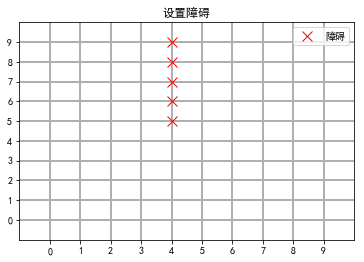

In [6]:
# 创建一个10*10的地图
mapw, maph = 10, 10
map2d = Array2D(mapw, maph)

# 设置障碍
obstacle = [[4, 9], [4, 8], [4, 7], [4, 6], [4, 5]]
for i in obstacle:
    map2d[i[0]][i[1]] = 1
# 显示地图设置障碍后的样子
Display_map(map2d, title="设置障碍")

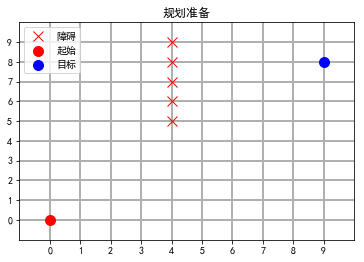

In [7]:
# 设置起点，终点
startx, starty = 0, 0
goalx, goaly = 9, 8
# 显示地图设置起点和终点后的样子
Display_map(map2d, [startx, starty], [goalx, goaly], title="规划准备")

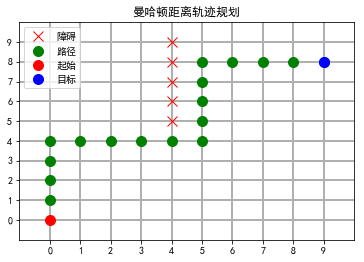

In [8]:
# 创建AStar对象，启动式函数为曼哈顿距离
aStar = AStar(map2d, Point(startx, starty), Point(goalx, goaly), hef='MD')
# 开始寻路
pathList = aStar.start()

# 遍历路径点,在map2d上以'o'表示
for point in pathList:
    map2d[point.x][point.y] = 'o'
# 再次显示地图
Display_map(map2d, [startx, starty], [goalx, goaly], title="曼哈顿距离轨迹规划")

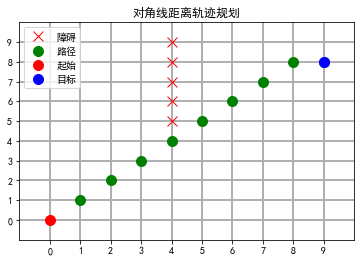

In [9]:
# 创建一个10*10的地图
mapw, maph = 10, 10
map2d = Array2D(mapw, maph)

# 设置障碍
obstacle = [[4, 9], [4, 8], [4, 7], [4, 6], [4, 5]]
for i in obstacle:
    map2d[i[0]][i[1]] = 1
    
# 创建AStar对象，启动式函数为对角线距离
aStar = AStar(map2d, Point(startx, starty), Point(goalx, goaly), hef='DD')
# 开始寻路
pathList = aStar.start()

# 遍历路径点,在map2d上以'o'表示
for point in pathList:
    map2d[point.x][point.y] = 'o'
# 再次显示地图
Display_map(map2d, [startx, starty], [goalx, goaly], title="对角线距离轨迹规划")

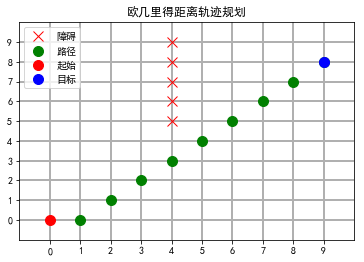

In [10]:
# 创建一个10*10的地图
mapw, maph = 10, 10
map2d = Array2D(mapw, maph)

# 设置障碍
obstacle = [[4, 9], [4, 8], [4, 7], [4, 6], [4, 5]]
for i in obstacle:
    map2d[i[0]][i[1]] = 1
    
# 创建AStar对象，启动式函数为欧几里得距离
aStar = AStar(map2d, Point(startx, starty), Point(goalx, goaly), hef='ED')
# 开始寻路
pathList = aStar.start()

# 遍历路径点,在map2d上以'o'表示
for point in pathList:
    map2d[point.x][point.y] = 'o'
# 再次显示地图
Display_map(map2d, [startx, starty], [goalx, goaly], title="欧几里得距离轨迹规划")